> Physics-Informed Neural Networks (PINNs) are a type of neural network that leverages both data and physical laws (represented by differential equations) to model complex systems. They are particularly useful for solving partial differential equations (PDEs), where traditional numerical methods may be computationally expensive or infeasible. PINNs incorporate these physical laws as part of the loss function, allowing the network to not only fit data but also adhere to the governing physics.

# Steps to Solve the Poisson Equation Using PINNs
1. Define the Neural Network: A fully connected neural network is used to approximate the solution 𝑢(𝑥,𝑦) of the Poisson equation.
2. Formulate the PDE Residual: The residual of the Poisson equation is derived by substituting the network's output into the equation.
3. Define the Loss Function: The loss function consists of two parts:
- PDE Loss: Ensures that the network's output satisfies the Poisson equation.
- Boundary Condition Loss: Ensures that the network satisfies the boundary conditions.
4. Train the Network: The network is trained by minimizing the combined loss.


Epoch 0, Loss: 0.954361617565155
Epoch 100, Loss: 0.05912613868713379
Epoch 200, Loss: 0.02467973157763481
Epoch 300, Loss: 0.013659277930855751
Epoch 400, Loss: 0.00864404533058405
Epoch 500, Loss: 0.006163511425256729
Epoch 600, Loss: 0.004665279295295477
Epoch 700, Loss: 0.0036173262633383274
Epoch 800, Loss: 0.0028102470096200705
Epoch 900, Loss: 0.002147518564015627
Epoch 1000, Loss: 0.001589298713952303
Epoch 1100, Loss: 0.00115762441419065
Epoch 1200, Loss: 0.0009111601393669844
Epoch 1300, Loss: 0.0007988134166225791
Epoch 1400, Loss: 0.0007308085914701223
Epoch 1500, Loss: 0.0006783304270356894
Epoch 1600, Loss: 0.0006340343970805407
Epoch 1700, Loss: 0.0005950522609055042
Epoch 1800, Loss: 0.0005601472221314907
Epoch 1900, Loss: 0.0005288685788400471
Epoch 2000, Loss: 0.000501116446685046
Epoch 2100, Loss: 0.00047687895130366087
Epoch 2200, Loss: 0.00045609098742716014
Epoch 2300, Loss: 0.00043857263517566025
Epoch 2400, Loss: 0.0004240268317516893
Epoch 2500, Loss: 0.0004120

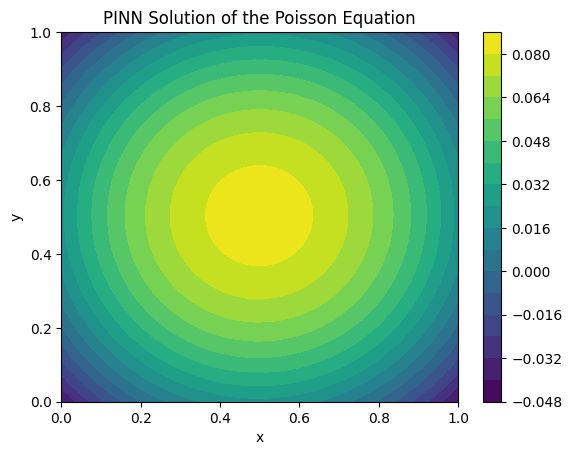

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(1, activation=None)

    def call(self, X):
        x = self.dense1(X)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

# Step 2: Define the physics-informed loss function
def pde_loss(model, X):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        u = model(X)
        u_x = tape.gradient(u, X)[:, 0:1]
        u_y = tape.gradient(u, X)[:, 1:2]
        u_xx = tape.gradient(u_x, X)[:, 0:1]
        u_yy = tape.gradient(u_y, X)[:, 1:2]
    del tape
    # Poisson equation residual (Δu = f(x, y))
    residual = u_xx + u_yy + 1.0  # assuming f(x, y) = -1
    return tf.reduce_mean(tf.square(residual))

# Step 3: Define the boundary condition loss
def boundary_loss(model, X_boundary):
    u_boundary = model(X_boundary)
    return tf.reduce_mean(tf.square(u_boundary))  # u = 0 on boundary

# Step 4: Total loss function
def total_loss(model, X, X_boundary):
    return pde_loss(model, X) + boundary_loss(model, X_boundary)

# Step 5: Generate training data (collocation points and boundary points)
def generate_training_data(N_collocation, N_boundary):
    # Collocation points inside the domain
    X_collocation = np.random.rand(N_collocation, 2)
    # Boundary points
    X_boundary = np.vstack([
        np.hstack([np.random.rand(N_boundary, 1), np.zeros((N_boundary, 1))]),
        np.hstack([np.zeros((N_boundary, 1)), np.random.rand(N_boundary, 1)]),
        np.hstack([np.ones((N_boundary, 1)), np.random.rand(N_boundary, 1)]),
        np.hstack([np.random.rand(N_boundary, 1), np.ones((N_boundary, 1))])
    ])
    return X_collocation, X_boundary

# Step 6: Train the PINN
def train_pinn(model, X, X_boundary, epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Convert numpy arrays to tensors
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    X_boundary = tf.convert_to_tensor(X_boundary, dtype=tf.float32)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss_value = total_loss(model, X, X_boundary)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss_value.numpy()}')

# Step 7: Visualize the solution
def plot_solution(model):
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    X_flat = X.flatten().reshape(-1, 1)
    Y_flat = Y.flatten().reshape(-1, 1)
    X_input = tf.convert_to_tensor(np.hstack([X_flat, Y_flat]), dtype=tf.float32)
    U_pred = model(X_input).numpy().reshape(100, 100)

    plt.contourf(X, Y, U_pred, 20, cmap='viridis')
    plt.colorbar()
    plt.title('PINN Solution of the Poisson Equation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Main script
N_collocation = 10000  # Number of collocation points
N_boundary = 400       # Number of boundary points
epochs = 5000          # Number of training epochs
learning_rate = 0.001  # Learning rate

X_collocation, X_boundary = generate_training_data(N_collocation, N_boundary)
model = PINN()
train_pinn(model, X_collocation, X_boundary, epochs, learning_rate)
plot_solution(model)




1. **Poisson Equation**: This is a partial differential equation of the form $\nabla^2 \phi = f$, where $\phi$ is the potential function and $f$ is a source term. It is commonly used in fields like electrostatics, fluid dynamics, and heat transfer.

2. **PINN**: Physics-Informed Neural Networks are a type of neural network that incorporates physical laws (like the Poisson equation) into the training process. This allows the model to learn solutions that are consistent with the underlying physics.

3. **Contour Plot**: The image shows a contour plot where:
   - The x-axis represents one spatial dimension (x).
   - The y-axis represents another spatial dimension (y).
   - The color gradient indicates the value of the solution $\phi$ at different points in the (x, y) plane.

4. **Color Scale**: The color bar on the right indicates the range of values for the solution, with different colors representing different magnitudes of $\phi$. The center of the plot likely represents a point of interest, such as a source or sink, where the potential is highest or lowest.

